# Nuclear Mass Neural Net

This short tensorflow toy trains a standard neural network to output binding energy based on an input neutron and proton number. The first code block uses a saved model and should stand by itself, but the training stuff is down below.

Also included are a couple of widgets. Be sure to run the first cell first to define some functions, then the widgets should run fine provided you have the environment set up correctly.

In [66]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)

# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# input N,Z return model estimated binding energy
def BE(N, Z):
    # Hard code the data averages
    zm=55.16940328394073
    nm=76.95234281137365
    Zs=(Z - zm) / zm
    Ns=(N - nm) / nm

    nucleus=np.array([[Zs,Ns]])

    [[BE]] = model.predict(nucleus,verbose=0)
    return BE

def GenerateMasses():
    zm=55.16940328394073
    nm=76.95234281137365
    nuclei=[[0,0]]
    for zi in range(1,120):
        Zs=(zi - zm) / zm
        for ni in range(0,160):
            Ns=(ni - nm) / nm
            nuclei=np.append(nuclei,[[Zs,Ns]],axis=0)
            
    energies=model.predict(nuclei,verbose=0)
    nuclei[:,0]=nuclei[:,0]*zm+zm
    nuclei[:,1]=nuclei[:,1]*nm+nm
    a_sum=np.sum(nuclei,axis=1)
    return pd.DataFrame({'A':a_sum,'Z':nuclei[:,0],'N':nuclei[:,1],'Energies':energies[:,0]*a_sum[:]})

def CalcSepEn(Z,A1,A2):
    Nucleus=predicted.loc[lambda predicted: predicted.Z==Z, :]
    Nucleus=Nucleus.loc[(Nucleus['A'] >= A1) & (Nucleus['A'] <= A2)]
    Nucleus['NeutronSeparationEnergies'] = Nucleus['Energies'].diff(+1)
    return Nucleus

    
# Given a Z value and number of separation, add neutron separation energies for the nucleus
#def NSepEn(Z,nsep,df):
#    for N in range[0:2*Z]:
        
# load our pretrained model
massmodel = tf.keras.models.load_model('neuralmasses.h5', custom_objects={'R2': R2})

# Generate a massive mass chart
predicted=GenerateMasses()

## Separation energy widget

Input a proton number and bounds for total A and watch what the neural net predicts. Note, some experimental data may have been used in the training! 

In [68]:
from ipywidgets import interactive,interact_manual
def f(Z,A1,A2):
    Nucleus=CalcSepEn(int(Z),int(A1),int(A2))
    MakePlot([Nucleus.A], [Nucleus.NeutronSeparationEnergies], ['b'], ['Neutron Separation Energy'], ['$A$','$S_n$'])
    plt.show()

interactive_plot = interact_manual(f, Z="Input Proton Number", A1="Input Minimum A", A2="Input Maximum A")

interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Minimum A', descri…

## Binding energy widget

Input Z and N to see what the neural net predicts for the binding energy.

In [71]:
from ipywidgets import interactive,interact_manual
def f(Z,N):
    A=int(Z)+int(N)
    pBE=BE(int(N),int(Z))
    print("Binding Energy per Nucleon:",pBE)
    print("Total Binding Energy:",pBE*A)

interactive = interact_manual(f, Z="Input Proton Number", N="Input Neutron Number")


interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Neutron Number', d…

In [ ]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx=xx.T
yy = Energies

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xs_train = x_train.astype(np.float64)
xs_test = x_test.astype(np.float64)

xs_train[:,0] = (x_train[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_test[:,0] = (x_test[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_train[:,1] = (x_train[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])
xs_test[:,1] = (x_test[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])

ys_train = y_train
ys_test = y_test

ys_train = y_train/np.std(yy)
ys_test = y_test/np.std(yy)


print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(xs_train.shape, xs_train.dtype))
print('Training Targets:\n   Shape: {}\n   Type: {}\n'.format(y_train.shape, ys_train.dtype))
print('Test Features:\n   Shape: {}\n   Type: {}\n'.format(xs_test.shape, xs_test.dtype))
print('Test Targets:\n   Shape: {}\n   Type: {}\n'.format(y_test.shape, ys_test.dtype))

nodes = 5000
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,ys_train,epochs=200, batch_size=16, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

en_out = en_out*np.std(yy)

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Features:
   Shape: (1997, 2)
   Type: float64

Training Targets:
   Shape: (1997,)
   Type: float64

Test Features:
   Shape: (500, 2)
   Type: float64

Test Targets:
   Shape: (500,)
   Type: float64

Train on 1597 samples, validate on 400 samples
Epoch 1/200
1597/1597 [==============================] - 43s 27ms/sample - loss: 23.6747 - R2: -57.5615 - val_loss: 1.0001 - val_R2: -0.4786
Epoch 2/200
  96/1597 [>.............................] - ETA: 39s - loss: 0.6524 - R2: -0.7395

### Run a little more

If you want to run further epochs with the output model as a starting point, this cell should do it for you

Train on 1597 samples, validate on 400 samples
Epoch 1/20
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0065 - R2: 0.9854 - val_loss: 0.0286 - val_R2: 0.9763
Epoch 2/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0461 - R2: 0.9249 - val_loss: 0.0664 - val_R2: 0.9592
Epoch 3/20
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0179 - R2: 0.9739 - val_loss: 0.0155 - val_R2: 0.9895
Epoch 4/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0092 - R2: 0.9852 - val_loss: 0.0325 - val_R2: 0.9803
Epoch 5/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0049 - R2: 0.9886 - val_loss: 0.0089 - val_R2: 0.9921
Epoch 6/20
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0036 - R2: 0.9884 - val_loss: 0.0144 - val_R2: 0.9891
Epoch 7/20
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0031 - R2: 0.9925 - val_loss: 0.0211 - val_R2: 0.9878
E

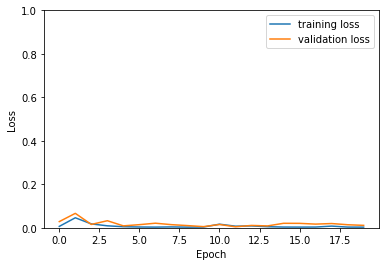

In [9]:
results=model.fit(xs_train,y_train,epochs=20, batch_size=16, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

### Make some predictions

We can, in principle, hand the neural net a N,Z array, and predict binding energies

In [21]:
N=8
Z=8

Zs=(Z - np.average(xx[:,0])) / np.average(xx[:,0])
Ns=(N - np.average(xx[:,1])) / np.average(xx[:,1])

nucleus=np.array([[Zs,Ns]])

[[BE]] = model.predict(nucleus)

print("Binding Energy Per Nucleon: ",BE)
print("Binding Energy: ",BE*(N+Z))

Binding Energy Per Nucleon:  7.6895247
Binding Energy:  123.03239440917969


## Save the model for posterity

Since it takes a long time to train

In [23]:
# This won't overwrite the 'real' trained github file
model.save('neuralmasses_testing.h5')
